In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [29]:
#  Set Random Seed for Reproducibility
np.random.seed(41)
tf.random.set_seed(42)
random.seed(42)

In [30]:
# Load the dataset
df = pd.read_csv("heart_disease.csv")

In [31]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [33]:
print(df.describe())

              age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%            30.000000             0.0

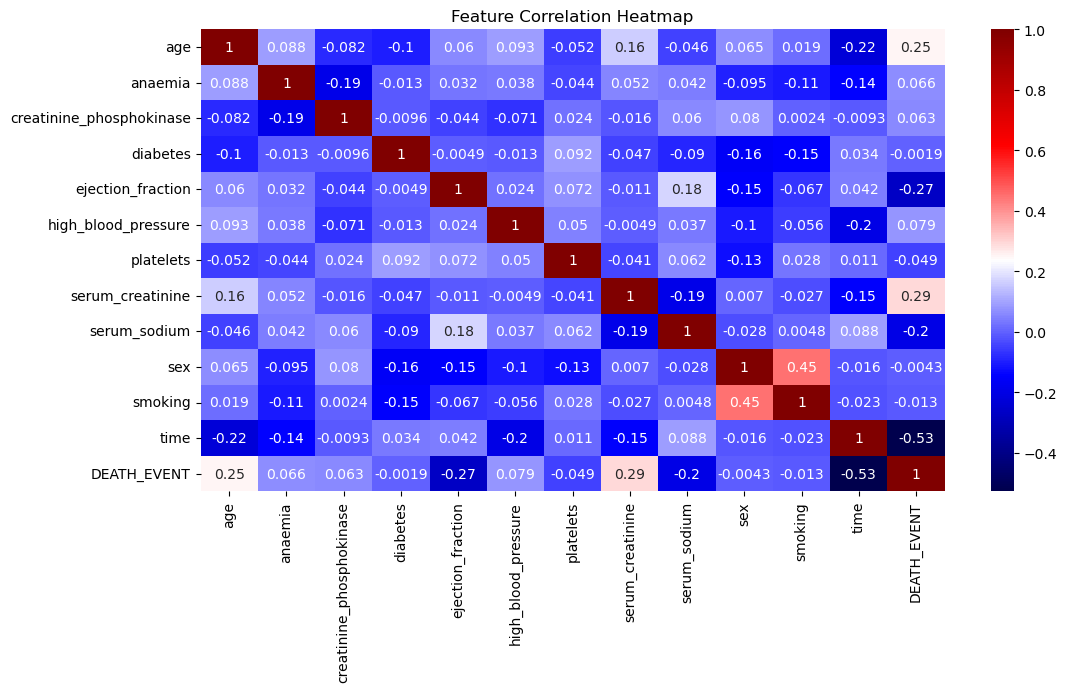

In [34]:
# Feature Selection using Correlation Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="seismic")
plt.title("Feature Correlation Heatmap")
plt.show()

In [35]:
df.drop(['anaemia','serum_creatinine','platelets','creatinine_phosphokinase' ], axis=1, inplace=True)

In [36]:
feature=['age','diabetes','ejection_fraction','high_blood_pressure','smoking', 'sex', 'time','serum_sodium',]
prediction_class=['DEATH_EVENT']

In [37]:
# Prepare the data
X = df[feature].values
y = df[prediction_class].values.ravel()  # Flatten Y to 1D array


In [38]:
# Normalize features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [39]:

# Train-test split with separate random states
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_scaled, y, test_size=0.2, random_state=63)
X_train_hgb, X_test_hgb, y_train_hgb, y_test_hgb = train_test_split(X_scaled, y, test_size=0.2, random_state=7)
X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(X_scaled, y, test_size=0.2, random_state=7)
# Standardize Features
scaler = StandardScaler()
X_train_ann = scaler.fit_transform(X_train_ann)
X_test_ann = scaler.transform(X_test_ann)


In [40]:
# Train SVM Model
svm_model = SVC(C=0.3,kernel='linear', gamma=2)
svm_model.fit(X_train_svm, y_train_svm)
svm_preds = svm_model.predict(X_test_svm)

In [41]:
# Train Histogram-based Gradient Boosting Model
hgb_model = HistGradientBoostingClassifier(
    learning_rate=0.03,
    max_iter=410,
    max_depth=2,
    min_samples_leaf=12,
    max_leaf_nodes=15,
    l2_regularization=0.708
)
hgb_model.fit(X_train_hgb, y_train_hgb)
hgb_preds = hgb_model.predict(X_test_hgb)

In [42]:
#  Build Neural Network Model
model = Sequential([
    Dense(125, activation="relu", kernel_initializer="uniform", input_dim=8),
    Dropout(0.3),
    Dense(110, activation="relu", kernel_initializer="uniform"),
    Dropout(0.3),
    Dense(70, activation="relu", kernel_initializer="uniform"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])
#  Compile Model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [43]:
# Train Model
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
history = model.fit(X_train_ann, y_train_ann, validation_split=0.2, batch_size=9, epochs=100, callbacks=[early_stop], verbose=1)

#  Evaluate Model on Test Data
loss, accuracy = model.evaluate(X_test_ann, y_test_ann, verbose=1)

#  Make Predictions
ann_preds = model.predict(X_test_ann)
ann_preds = (ann_preds > 0.5).astype(int)  # Convert probabilities to binary (0/1)


Epoch 1/100
22/22 [==============================] - 3s 40ms/step - loss: 0.6846 - accuracy: 0.6283 - val_loss: 0.6607 - val_accuracy: 0.6875
Epoch 2/100
22/22 [==============================] - 0s 12ms/step - loss: 0.6218 - accuracy: 0.6492 - val_loss: 0.5401 - val_accuracy: 0.6875
Epoch 3/100
22/22 [==============================] - 0s 13ms/step - loss: 0.5076 - accuracy: 0.7225 - val_loss: 0.4851 - val_accuracy: 0.7083
Epoch 4/100
22/22 [==============================] - 0s 12ms/step - loss: 0.4571 - accuracy: 0.8063 - val_loss: 0.4482 - val_accuracy: 0.8125
Epoch 5/100
22/22 [==============================] - 0s 12ms/step - loss: 0.4142 - accuracy: 0.8429 - val_loss: 0.4535 - val_accuracy: 0.7917
Epoch 6/100
22/22 [==============================] - 0s 12ms/step - loss: 0.3911 - accuracy: 0.8377 - val_loss: 0.4728 - val_accuracy: 0.8125
Epoch 7/100
22/22 [==============================] - 0s 12ms/step - loss: 0.3969 - accuracy: 0.8377 - val_loss: 0.4736 - val_accuracy: 0.8333
Epoch 

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Model Evaluation
def evaluate_model(name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    # Check if binary classification for specificity calculation
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    else:
        specificity = None  # Not defined for multiclass

    print(f"{name} Model Performance:")
    print("Accuracy: {:.2f}%".format(accuracy_score(y_true, y_pred) * 100))
    print("Precision: {:.2f}%".format(precision_score(y_true, y_pred) * 100))
    print("Recall (Sensitivity): {:.2f}%".format(recall_score(y_true, y_pred) * 100))
    if specificity is not None:
        print("Specificity: {:.2f}%".format(specificity * 100))
    else:
        print("Specificity: N/A (not binary classification)")
    print("F1 Score: {:.2f}%".format(f1_score(y_true, y_pred) * 100))
    print("Confusion Matrix:\n", cm)
    print("\n")

# Evaluating models
evaluate_model("SVM", y_test_svm, svm_preds)
evaluate_model("HGB", y_test_hgb, hgb_preds)
evaluate_model("ANN", y_test_ann, ann_preds)


SVM Model Performance:
Accuracy: 85.00%
Precision: 77.78%
Recall (Sensitivity): 50.00%
Specificity: 95.65%
F1 Score: 60.87%
Confusion Matrix:
 [[44  2]
 [ 7  7]]


HGB Model Performance:
Accuracy: 93.33%
Precision: 91.67%
Recall (Sensitivity): 78.57%
Specificity: 97.83%
F1 Score: 84.62%
Confusion Matrix:
 [[45  1]
 [ 3 11]]


ANN Model Performance:
Accuracy: 88.33%
Precision: 81.82%
Recall (Sensitivity): 64.29%
Specificity: 95.65%
F1 Score: 72.00%
Confusion Matrix:
 [[44  2]
 [ 5  9]]




<Figure size 1000x600 with 0 Axes>

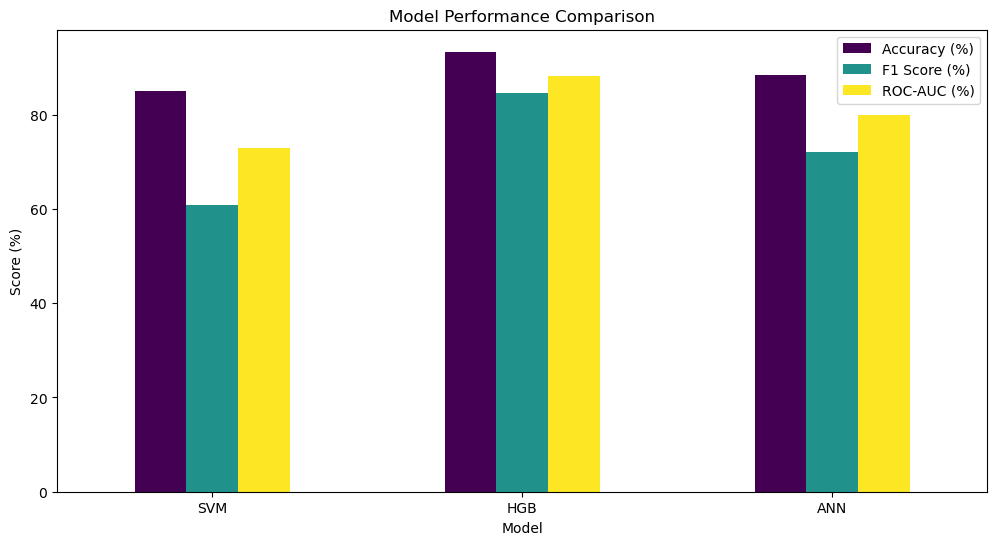

In [45]:
# Visualization
models = ["SVM", "HGB", "ANN"]
accuracies = [
    accuracy_score(y_test_svm, svm_preds) * 100,
    accuracy_score(y_test_hgb, hgb_preds) * 100,
    accuracy_score(y_test_ann, ann_preds) * 100
]

f1_scores = [
    f1_score(y_test_svm, svm_preds) * 100,
    f1_score(y_test_hgb, hgb_preds) * 100,
    f1_score(y_test_ann, ann_preds) * 100
]

roc_auc_scores = [
    roc_auc_score(y_test_svm, svm_preds) * 100,
    roc_auc_score(y_test_hgb, hgb_preds) * 100,
    roc_auc_score(y_test_ann, ann_preds) * 100
]

plt.figure(figsize=(10, 6))
metrics_df = pd.DataFrame({"Model": models, "Accuracy (%)": accuracies, "F1 Score (%)": f1_scores, "ROC-AUC (%)": roc_auc_scores})
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 6), colormap="viridis")
plt.title("Model Performance Comparison")
plt.ylabel("Score (%)")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()


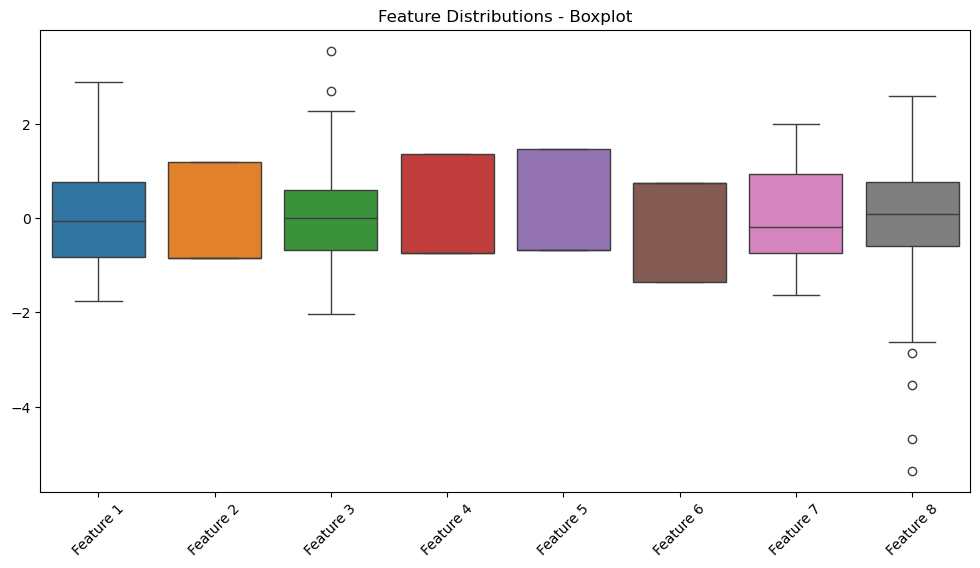

In [46]:
# Boxplot of Feature Distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=pd.DataFrame(X_scaled, columns=X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i+1}' for i in range(X_scaled.shape[1])]))
plt.title("Feature Distributions - Boxplot")
plt.xticks(rotation=45)
plt.show()


C:\Users\govin\AppData\Local\Temp\ipykernel_6188\2670358657.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


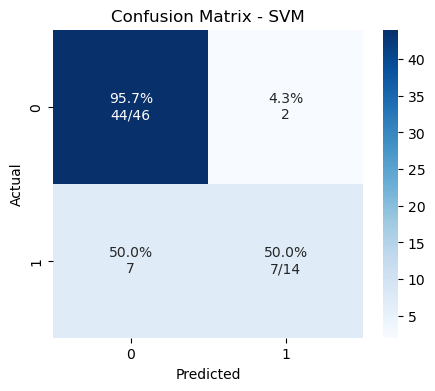

C:\Users\govin\AppData\Local\Temp\ipykernel_6188\2670358657.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


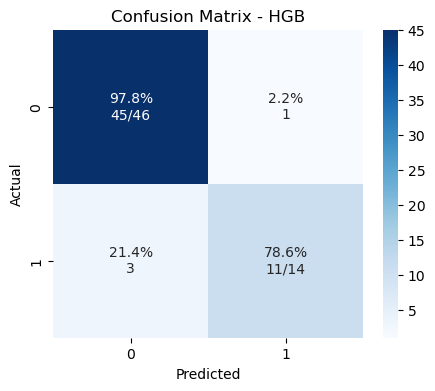

C:\Users\govin\AppData\Local\Temp\ipykernel_6188\2670358657.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


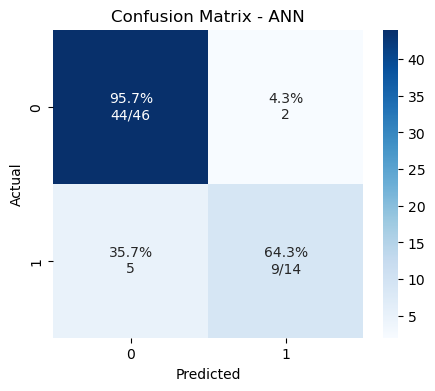

In [47]:
# Confusion Matrix Function
def cm_analysis(y_true, y_pred, labels, model_name, ymap=None, figsize=(5, 4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels) 
    cm_df.index.name = 'Actual' 
    cm_df.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm_df, annot=annot, fmt='', ax=ax, cmap="Blues") 
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Plot confusion matrices for all models
cm_analysis(y_test_svm, svm_preds, labels=[0, 1], model_name="SVM")
cm_analysis(y_test_hgb, hgb_preds, labels=[0, 1], model_name="HGB")
cm_analysis(y_test_ann, ann_preds, labels=[0, 1], model_name="ANN")


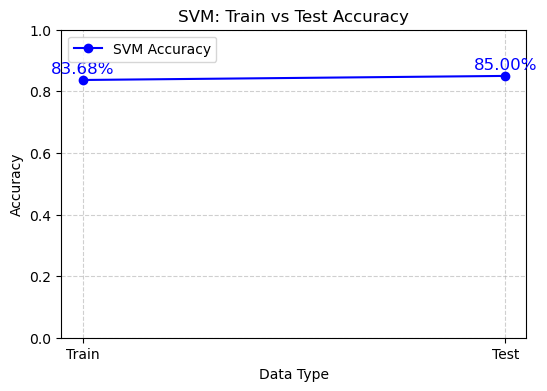

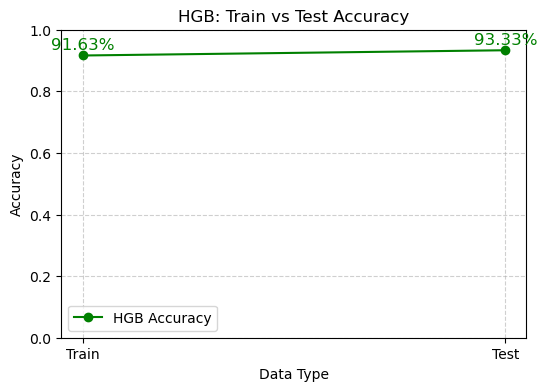

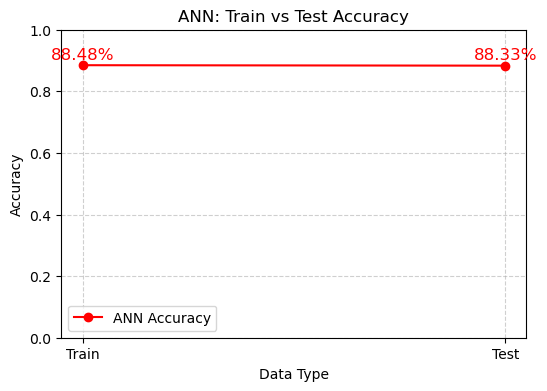

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Compute Train and Test Accuracy for each model
svm_train_acc = accuracy_score(y_train_svm, svm_model.predict(X_train_svm))
svm_test_acc = accuracy_score(y_test_svm, svm_preds)

hgb_train_acc = accuracy_score(y_train_hgb, hgb_model.predict(X_train_hgb))
hgb_test_acc = accuracy_score(y_test_hgb, hgb_preds)

ann_train_acc = history.history['accuracy'][-1]  # Last epoch train accuracy
ann_test_acc = accuracy_score(y_test_ann, ann_preds)

#  SVM Plot
plt.figure(figsize=(6, 4))
plt.plot(['Train', 'Test'], [svm_train_acc, svm_test_acc], marker='o', linestyle='-', color='blue', label='SVM Accuracy')
plt.xlabel('Data Type')
plt.ylabel('Accuracy')
plt.title('SVM: Train vs Test Accuracy')
plt.ylim([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.text('Train', svm_train_acc + 0.02, f"{svm_train_acc:.2%}", ha='center', fontsize=12, color='blue')
plt.text('Test', svm_test_acc + 0.02, f"{svm_test_acc:.2%}", ha='center', fontsize=12, color='blue')
plt.legend()
plt.show()


#  HGB Plot
plt.figure(figsize=(6, 4))
plt.plot(['Train', 'Test'], [hgb_train_acc, hgb_test_acc], marker='o', linestyle='-', color='green', label='HGB Accuracy')
plt.xlabel('Data Type')
plt.ylabel('Accuracy')
plt.title('HGB: Train vs Test Accuracy')
plt.ylim([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.text('Train', hgb_train_acc + 0.02, f"{hgb_train_acc:.2%}", ha='center', fontsize=12, color='green')
plt.text('Test', hgb_test_acc + 0.02, f"{hgb_test_acc:.2%}", ha='center', fontsize=12, color='green')
plt.legend()
plt.show()


#  ANN Plot
plt.figure(figsize=(6, 4))
plt.plot(['Train', 'Test'], [ann_train_acc, ann_test_acc], marker='o', linestyle='-', color='red', label='ANN Accuracy')
plt.xlabel('Data Type')
plt.ylabel('Accuracy')
plt.title('ANN: Train vs Test Accuracy')
plt.ylim([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.text('Train', ann_train_acc + 0.02, f"{ann_train_acc:.2%}", ha='center', fontsize=12, color='red')
plt.text('Test', ann_test_acc + 0.02, f"{ann_test_acc:.2%}", ha='center', fontsize=12, color='red')
plt.legend()
plt.show()


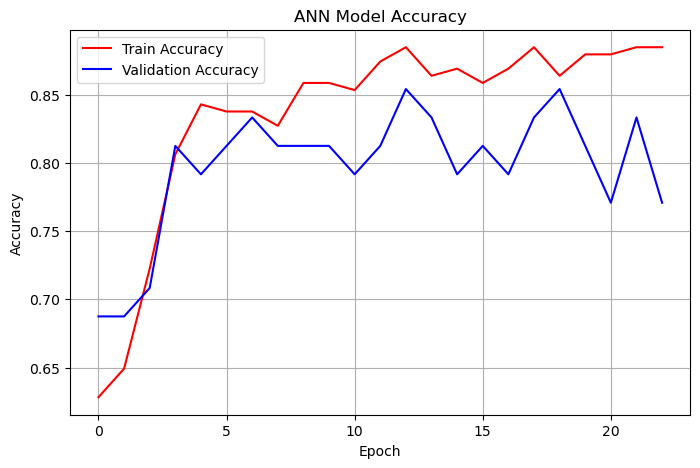

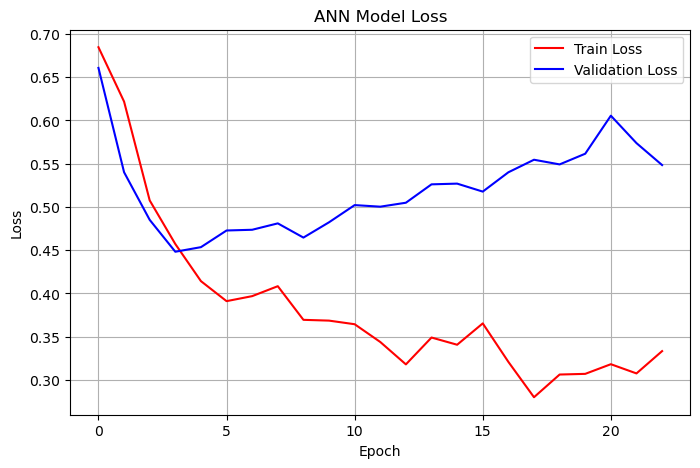

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Ensure inline plotting
%matplotlib inline  

#  ANN: Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], color='red', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.title('ANN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

#  ANN: Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='red', label='Train Loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')
plt.title('ANN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


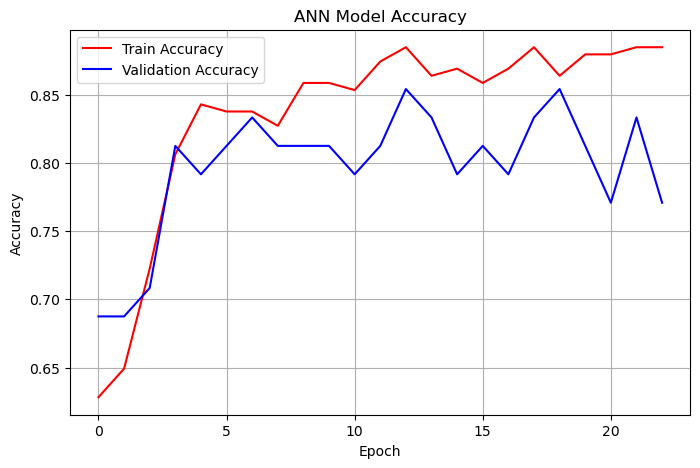

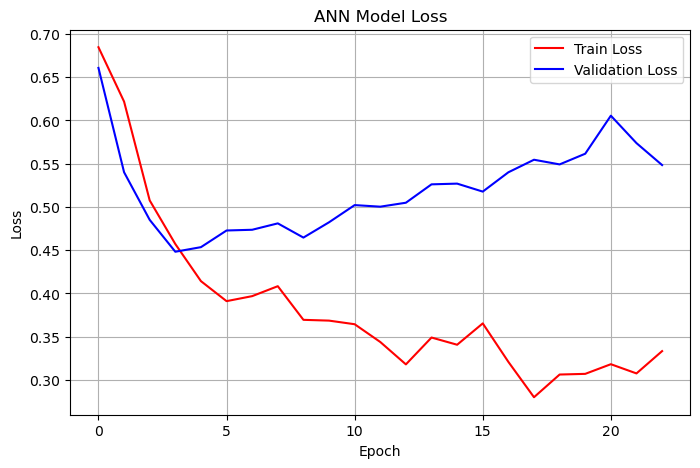

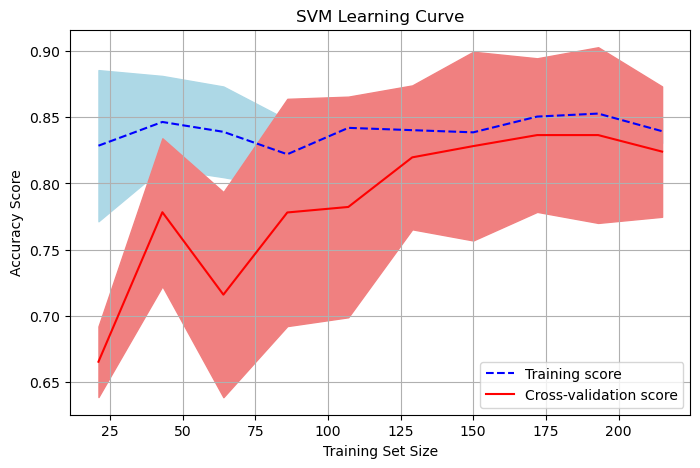

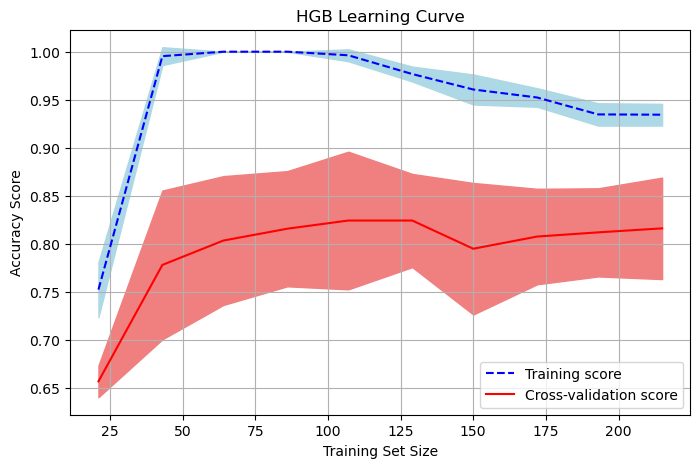

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier

#  ANN: Accuracy & Loss Plots
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], color='red', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.title('ANN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='red', label='Train Loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')
plt.title('ANN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

#  Compute Accuracy for All Models
svm_train_acc = accuracy_score(y_train_svm, svm_model.predict(X_train_svm))
svm_test_acc = accuracy_score(y_test_svm, svm_model.predict(X_test_svm))

hgb_train_acc = accuracy_score(y_train_hgb, hgb_model.predict(X_train_hgb))
hgb_test_acc = accuracy_score(y_test_hgb, hgb_model.predict(X_test_hgb))

ann_train_acc = history.history['accuracy'][-1]  # Last epoch accuracy
ann_test_acc = history.history['val_accuracy'][-1]  # Last epoch validation accuracy



#  Learning Curve Function
def plot_learning_curve(model, X_train, y_train, title):
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            X_train, 
                                                            y_train, 
                                                            cv=10, 
                                                            scoring='accuracy', 
                                                            n_jobs=-1, 
                                                            train_sizes=np.linspace(0.1, 1.0, 10))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, '--', color="blue", label="Training score")
    plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="lightblue")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="lightcoral")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

#  Learning Curves for SVM & HGB
plot_learning_curve(SVC(kernel="linear", C=0.3), X_train_svm, y_train_svm, "SVM Learning Curve")
plot_learning_curve(HistGradientBoostingClassifier(learning_rate=0.037, max_iter=410, max_depth=2, 
                                                   min_samples_leaf=12, max_leaf_nodes=15), 
                    X_train_hgb, y_train_hgb, "HGB Learning Curve")


2/2 [==============================] - 0s 10ms/step


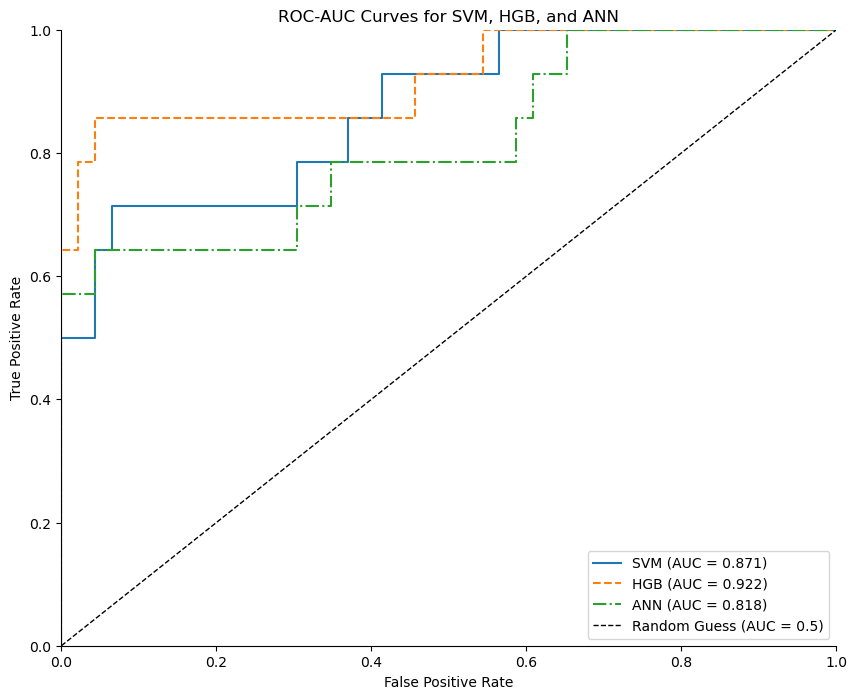

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

#  Function to Plot ROC-AUC Curve
def roc_auc_plot(y_true, y_proba, label=' ', linestyle='-'):
    """Plots ROC Curve for a given model's probability predictions"""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    ax.plot(fpr, tpr, linestyle=linestyle, linewidth=1.5, label=f"{label} (AUC = {auc_score:.3f})")

#  Initialize Plot
fig, ax = plt.subplots(figsize=(10, 8))

# ROC-AUC for SVM (using decision function)
y_proba_svm = svm_model.decision_function(X_test_svm)  # Decision scores, treated as probabilities
roc_auc_plot(y_test_svm, y_proba_svm, label="SVM", linestyle='-')

#  ROC-AUC for HGB
y_proba_hgb = hgb_model.predict_proba(X_test_hgb)[:, 1]  # Select probabilities of class 1
roc_auc_plot(y_test_hgb, y_proba_hgb, label="HGB", linestyle='--')

#  ROC-AUC for ANN
y_proba_ann = model.predict(X_test_ann).flatten()  # Convert ANN output to 1D
roc_auc_plot(y_test_ann, y_proba_ann, label="ANN", linestyle='-.')

#  Diagonal Baseline
ax.plot([0, 1], [0, 1], color='k', linewidth=1.0, linestyle='--', label="Random Guess (AUC = 0.5)")

#  Final Touches
ax.legend(loc="lower right")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('ROC-AUC Curves for SVM, HGB, and ANN')
sns.despine()

plt.show()


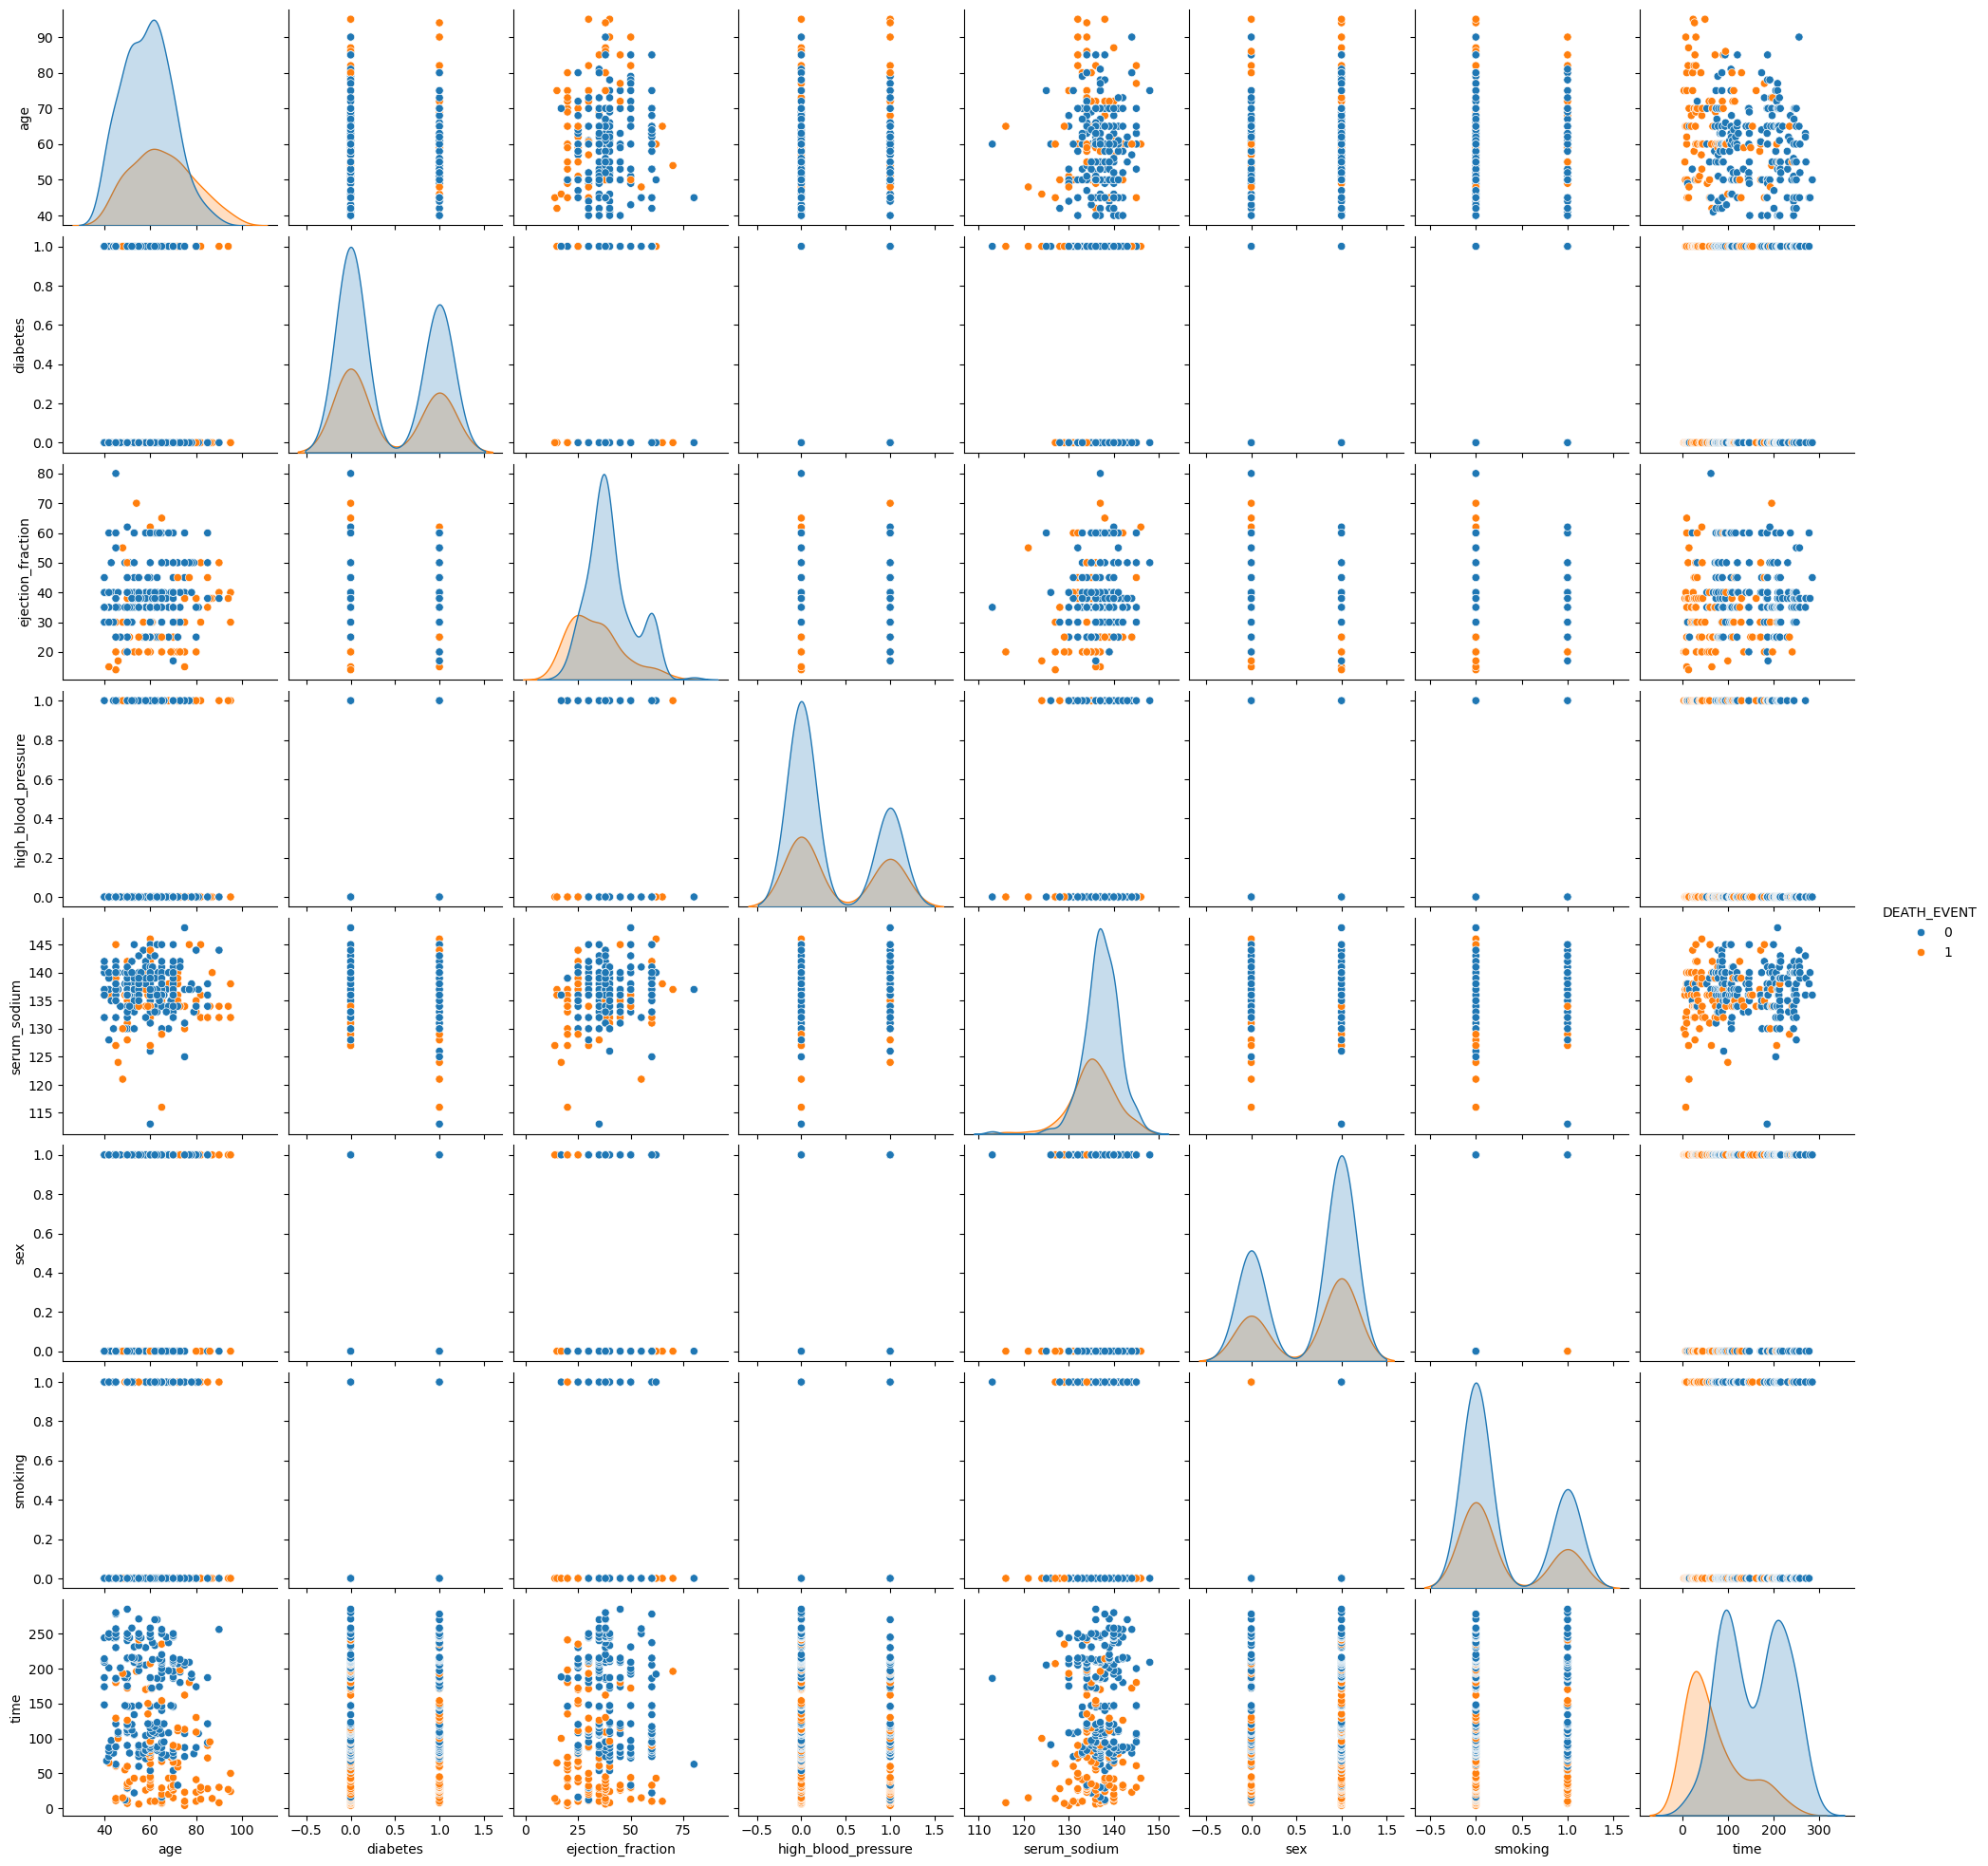

In [52]:
# Pairplot for Feature Relationships
sns.pairplot(df, hue="DEATH_EVENT", diag_kind="kde")
plt.show()